# Uniqueness based on place365 scenes

In [53]:
import argparse
import json
import os
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from PIL import Image, ImageFile
from tqdm import tqdm
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

import src.model
from src.dataset import AirbnbDataset, AirbnbNYDataset

ImageFile.LOAD_TRUNCATED_IMAGES = True
device = "cuda" if torch.cuda.is_available() else "cpu"


def print_w_scenes(ds, uniqueness, indices=None, scene="bedroom", most_unique=1000, most_common=None, seed=42, display_index=True):
    np.random.seed(seed)
    
    ## get top-k unique images
    if indices is None:
        uniqueness = uniqueness[uniqueness["scene"]==scene]    
        if most_unique is not None:
            samples = uniqueness.nsmallest(most_unique, columns=["loss"])
        if most_common is not None:
            samples = uniqueness.nlargest(most_common, columns=["loss"])
        indices = samples.sample(30).index
    else:
        samples = uniqueness.reindex(indices)
    if display_index:
        display(indices.to_frame())

    # load the test image
    if isinstance(indices, pd.MultiIndex):
        mapping = ds.idx_mapping.reset_index().set_index(["idx_image","image_id"])
    else:
        mapping = ds.idx_mapping.reset_index().set_index("image_id")
    
    prefix = "most common in" if most_common else "most unique in"
    print(f"{prefix} scene: {scene}")
    rows = int(len(indices) // 10)
    rows = 1 if rows == 0 else rows
    fig = plt.figure(figsize=(20, 3 * rows - 1))

    for i, it in enumerate(indices):
        ax = fig.add_subplot(rows, 10, i+1)
        idx = mapping.loc[it]["index"]
        img = ds[idx]["image"].reshape(224, 224, 3).astype('uint8')

        # plot
        plt.imshow(img)
        ax.set_title(f"score:{uniqueness.loc[it][0]:.1f}")
        plt.axis('off')
        plt.tight_layout()
        

def set_seed(seed=42, cuda_deterministic=True):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if cuda_deterministic:  # slower, more reproducible
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:  # faster, less reproducible
        torch.backends.cudnn.deterministic = False
        torch.backends.cudnn.benchmark = True


def load_state_dict_unsafe(model, state_dict):
    """
    Load state dict to provided model while ignore exceptions.
    """

    missing_keys = []
    unexpected_keys = []
    error_msgs = []

    # copy state_dict so _load_from_state_dict can modify it
    metadata = getattr(state_dict, "_metadata", None)
    state_dict = state_dict.copy()
    if metadata is not None:
        state_dict._metadata = metadata

    def load(module, prefix=""):
        local_metadata = {} if metadata is None else metadata.get(prefix[:-1], {})
        module._load_from_state_dict(
            state_dict,
            prefix,
            local_metadata,
            True,
            missing_keys,
            unexpected_keys,
            error_msgs,
        )
        for name, child in module._modules.items():
            if child is not None:
                load(child, prefix + name + ".")

    load(model)
    load = None  # break load->load reference cycle

    return {
        "unexpected_keys": unexpected_keys,
        "missing_keys": missing_keys,
        "error_msgs": error_msgs,
    }


class RELAX(nn.Module):
    def __init__(self, x, f, num_batches, batch_size):
        super().__init__()

        self.batch_size = batch_size
        self.shape = tuple(x.shape[2:])
        self.num_batches = num_batches
        self.pdist = nn.CosineSimilarity(dim=1)

        self.x = x
        self.encoder = f
        h_star = f(self.x)
        self.h_star = h_star.expand(batch_size, -1)

        self.R = torch.zeros(self.shape, device=device)
        self.U = torch.zeros(self.shape, device=device)

        self.sum_of_weights = (1e-10)*torch.ones(self.shape, device=device)

    def forward(self):

        for batch in range(self.num_batches):
            for masks in self.mask_generator():

                x_mask = self.x * masks
                h = self.encoder(x_mask)
                sims = self.pdist(self.h_star, h)

                for si, mi in zip(sims, masks.squeeze()):

                    W_prev = self.sum_of_weights
                    self.sum_of_weights += mi

                    R_prev = self.R.clone()
                    self.R = self.R + mi*(si-self.R) / self.sum_of_weights
                    self.U = self.U + (si-self.R) * (si-R_prev) * mi

        return None

    def importance(self):
        return self.R

    def uncertainty(self):
        return self.U / (self.sum_of_weights - 1)

    def mask_generator(self, num_cells=7, p=0.5, nsd=2):

        pad_size = (num_cells // 2, num_cells // 2, num_cells // 2, num_cells // 2)

        grid = (torch.rand(self.batch_size, 1, *((num_cells,) * nsd), device=device) < p).float()
        grid_up = F.interpolate(grid, size=(self.shape), mode='bilinear', align_corners=False)
        grid_up = F.pad(grid_up, pad_size, mode='reflect')

        shift_x = torch.randint(0, num_cells, (self.batch_size,), device=device)
        shift_y = torch.randint(0, num_cells, (self.batch_size,), device=device)

        masks = torch.empty((self.batch_size, 1, self.shape[-2], self.shape[-1]), device=device)

        for bi in range(self.batch_size):
            masks[bi] = grid_up[bi, :,
                                shift_x[bi]:shift_x[bi] + self.shape[-2],
                                shift_y[bi]:shift_y[bi] + self.shape[-1]]

        yield masks
        
        
def get_RELAX_list(ds, uniqueness, model, indices, scene, most_unique, most_common, seed):
    
    np.random.seed(seed)
    ## get top-k unique images
    if indices is None:
        uniqueness = uniqueness[uniqueness["scene"]==scene]    
        if most_unique is not None:
            samples = uniqueness.nsmallest(most_unique, columns=["loss"])
        if most_common is not None:
            samples = uniqueness.nlargest(most_common, columns=["loss"])
        indices = np.random.choice(samples.index.tolist(),30,replace=False)
    else:
        samples = uniqueness.reindex(indices)

    if isinstance(indices, pd.MultiIndex):
        mapping = ds.idx_mapping.reset_index().set_index(["idx_image","image_id"])
    else:
        mapping = ds.idx_mapping.reset_index().set_index("image_id")

    ## inference
    relax_list = []
    tsfm_imgs, raw = [], []
    mask_bs = 100
    num_batches = 30

    for idx in tqdm(indices):
        x = ds[mapping.loc[idx]["index"]]["image"]
        tsfm = torchvision.transforms.Compose([
            #torchvision.transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
            ),
        ])
        x = tsfm(torchvision.transforms.ToPILImage()(x)).reshape(1, 3, 224, 224)
        tsfm_imgs.append(x)

        with torch.no_grad():
            relax = RELAX(x, model, num_batches, mask_bs)
            relax.forward()

        relax_list.append(relax)
        
    return relax_list, tsfm_imgs, indices
    
    
def to_np(x):
    return x.cpu().detach().numpy()


def imsc(img, *args, quiet=False, lim=None, interpolation='lanczos', **kwargs):
    if isinstance(img, Image.Image):
        img = pil_to_tensor(img)
    handle = None
    with torch.no_grad():
        if not lim:
            lim = [img.min(), img.max()]
        img = img - lim[0]  # also makes a copy
        img.mul_(1 / (lim[1] - lim[0]))
        img = torch.clamp(img, min=0, max=1)
        if not quiet:
            bitmap = img.expand(3,
                        *img.shape[1:]).permute(1, 2, 0).cpu().numpy()
    return bitmap


def show_RELAX_one_img(ds, uniqueness, model, indices=None, scene="bedroom", most_unique=1000, most_common=None, seed=42):
    relax_list, tsfm_imgs, indices = get_RELAX_list(ds, uniqueness, model, indices, scene, most_unique, most_common, seed)

    fig, axes = plt.subplots(1,3, figsize=(16, 8))
    
    ## importance
    model_explanation, idx = relax_list[0], indices[0]
    ax = axes[0]
    ax.set_ylabel('Importance', fontsize=15)
    ax.imshow(imsc(tsfm_imgs[0].squeeze()))
    im = ax.imshow(to_np(model_explanation.importance()), alpha=0.75, cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"score:{uniqueness.loc[idx][0]:.2f}", fontsize=15)
    
    ## uncertainty
    ax = axes[1]
    ax.set_ylabel('Uncertainty', fontsize=15)
    ax.imshow(imsc(tsfm_imgs[0].squeeze()))
    ax.imshow(to_np(model_explanation.uncertainty()), alpha=0.75, cmap='bwr')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(idx, fontsize=font_size)
    
    ## original
    ax = axes[2]
    ax.set_ylabel('Raw', fontsize=15)
    ax.imshow(imsc(tsfm_imgs[0].squeeze()))
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_title(idx, fontsize=font_size)
    plt.tight_layout()

    plt.show()

    
def show_RELAX(ds, uniqueness, model, indices=None, scene="bedroom", most_unique=1000, most_common=None, seed=42):
    relax_list, tsfm_imgs, indices = get_RELAX_list(ds, uniqueness, model, indices, scene, most_unique, most_common, seed)

    fig = plt.figure(1, figsize=(16, 8))
    font_size = 15

    gs = gridspec.GridSpec(6, 20)

    for i, (model_explanation, idx) in enumerate(zip(relax_list, indices)):

        ax = plt.subplot(gs[0:2, 2*(i):2*(1+i)])
        if i == 0: 
            ax.set_ylabel('Importance', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))
        im = ax.imshow(to_np(model_explanation.importance()), alpha=0.75, cmap='bwr')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"score:{uniqueness.loc[idx][0]:.2f}", fontsize=font_size)

        ax = plt.subplot(gs[2:4, 2*(i):2*(1+i)])
        if i == 0: ax.set_ylabel('Uncertainty', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))

        ax.imshow(to_np(model_explanation.uncertainty()), alpha=0.75, cmap='bwr')
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_title(idx, fontsize=font_size)

        ax = plt.subplot(gs[4:6, 2*(i):2*(1+i)])
        if i == 0: ax.set_ylabel('Raw', fontsize=font_size)

        ax.imshow(imsc(tsfm_imgs[i].squeeze()))
        ax.set_xticks([])
        ax.set_yticks([])
        #ax.set_title(idx, fontsize=font_size)


    cbar_ax = fig.add_axes([0.98, 0.05, 0.01, 0.86])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_ticks([])

    plt.tight_layout()
    plt.show()


In [2]:
## uniqueness file
file_path = "./output/08-05_01:37:26" # "./output/06-22_19:15:53/"
uniqueness = pd.read_pickle(file_path + "/uniqueness.pkl")

## load model
model = src.model.MoCo(torchvision.models.__dict__["resnet18"], K=65280)
res = load_state_dict_unsafe(
        model, torch.load(file_path + "/model.pt", map_location="cpu")
    )
model = model.encoder_q
model.fc = nn.Linear(512, 128, bias=False)

## dataset
# inpath = "/export/projects2/szhang_text_project/Airbnb_unique/photo_library/"
inpath = "/export/projects2/szhang_text_project/Airbnb_Images_NYC/photos.hdf5"
ds = AirbnbNYDataset(inpath)

,,property_id,image_id
property_id,image_id,,
45958158,600087be-1da8-489c-a679-e8945cf8d83a,45958158,600087be-1da8-489c-a679-e8945cf8d83a
2076101,408a5b4d-c5b2-40ef-a02a-9c20feabcdd6,2076101,408a5b4d-c5b2-40ef-a02a-9c20feabcdd6
2772111,38110165#02a91b10_original,2772111,38110165#02a91b10_original
7244824,17e60552-261c-4aba-8834-107503704462,7244824,17e60552-261c-4aba-8834-107503704462
23106361,f3b8ecee-8a53-451c-af52-4b1753a5cf50,23106361,f3b8ecee-8a53-451c-af52-4b1753a5cf50
11167618,d73f9163-8d48-48bf-8818-75892676f292,11167618,d73f9163-8d48-48bf-8818-75892676f292
39289019,38e1229f-2abd-4061-946e-2594f95e9d11,39289019,38e1229f-2abd-4061-946e-2594f95e9d11
26534838,8ac690e0-d057-454e-9fe3-596c992f2946,26534838,8ac690e0-d057-454e-9fe3-596c992f2946
26313558,0402d62f-673c-4fb3-bf05-d82901202c1e,26313558,0402d62f-673c-4fb3-bf05-d82901202c1e


most common in scene: bathroom


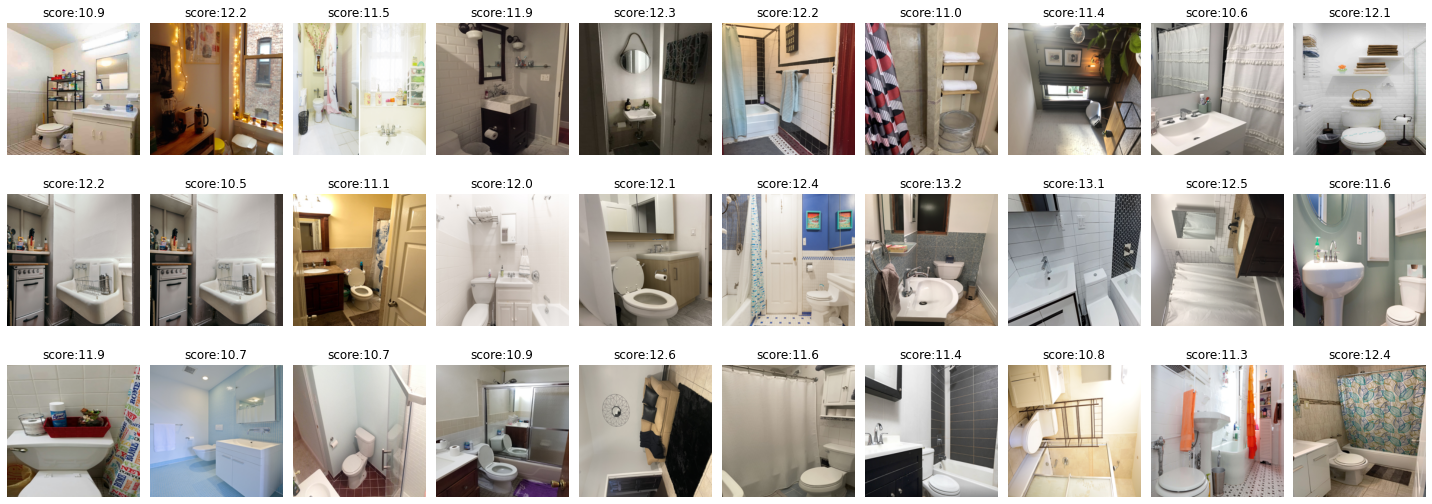

In [46]:
print_w_scenes(ds, uniqueness, indices=None, scene="bathroom", most_unique=None, most_common=25000, seed=1)

# Show where is unique

## Eyeballing and Sampling here 

In [50]:
idx_unique = {
    "bedroom": pd.MultiIndex.from_tuples([("40409517","714dbbeb-aef1-4037-b447-437d732ea435"),]), 
    "kitchen": pd.MultiIndex.from_tuples([None]),
    "living_room": pd.MultiIndex.from_tuples([None]),
    "bathroom": pd.MultiIndex.from_tuples([None]),
}

idx_common = {
    "bedroom": pd.MultiIndex.from_tuples([("49484281","miso#Hosting-49484281#original#e3018322-f98b-4120-9162-428ea76fe2b8.jpeg"), ]),
    "kitchen": pd.MultiIndex.from_tuples([("25264664","39f10396-c8ed-4764-8ea1-748900ddfc99")]),
    "living_room": pd.MultiIndex.from_tuples([("46667674","prohost-api#Hosting-46667674#original#c0e4b1ad-b9dc-4476-b4b3-1248e08d2c69.jpeg")]),
    "bathroom": pd.MultiIndex.from_tuples([("16793649","f98c2c25-bbd6-4446-b0a8-7373f2c5189e")]),
}


most unique in scene: bedroom


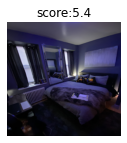

In [32]:
print_w_scenes(ds, uniqueness, indices=idx_unique["bedroom"], scene="bedroom", most_unique=1, most_common=None, display_index=False)
# print_w_scenes(ds, uniqueness, indices=idx_unique["kitchen"], scene="kitchen", most_unique=1, most_common=None, display_index=False)
# print_w_scenes(ds, uniqueness, indices=idx_unique["living_room"], scene="living_room", most_unique=1, most_common=None, display_index=False)
# print_w_scenes(ds, uniqueness, indices=idx_unique["bathroom"], scene="bathroom", most_unique=1, most_common=None, display_index=False)


most common in scene: bedroom
most common in scene: kitchen
most common in scene: living_room
most common in scene: bathroom


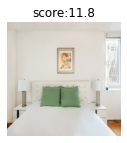

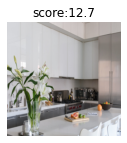

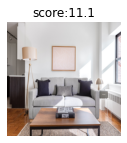

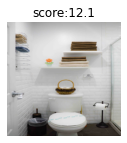

In [52]:
print_w_scenes(ds, uniqueness, indices=idx_common["bedroom"], scene="bedroom", most_unique=None, most_common=1, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_common["kitchen"], scene="kitchen", most_unique=None, most_common=1, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_common["living_room"], scene="living_room", most_unique=None, most_common=1, display_index=False)
print_w_scenes(ds, uniqueness, indices=idx_common["bathroom"], scene="bathroom", most_unique=None, most_common=1, display_index=False)


## RELAX-Common

100%|██████████| 1/1 [00:28<00:00, 28.81s/it]


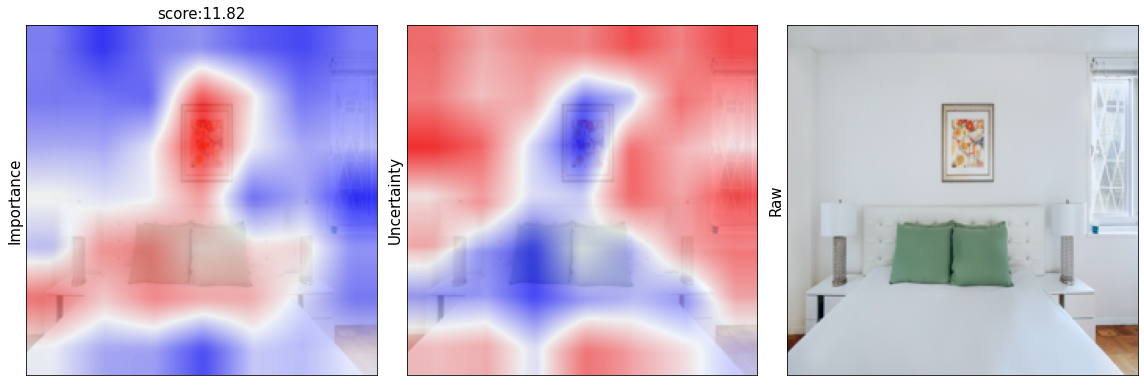

In [54]:
show_RELAX_one_img(ds, uniqueness, model, indices=idx_common["bedroom"], scene="bedroom", most_unique=None, most_common=1)

100%|██████████| 1/1 [00:27<00:00, 27.77s/it]


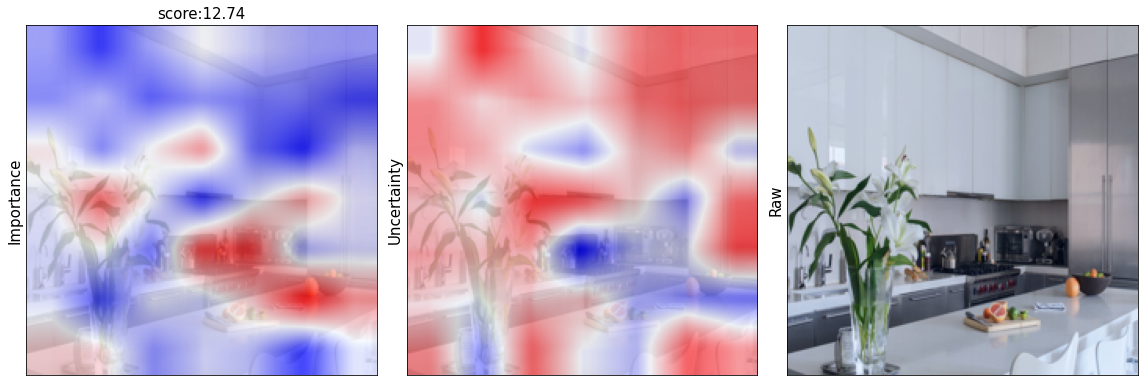

In [56]:
show_RELAX_one_img(ds, uniqueness, model, indices=idx_common["kitchen"], scene="kitchen", most_unique=None, most_common=1)

100%|██████████| 1/1 [00:29<00:00, 29.16s/it]


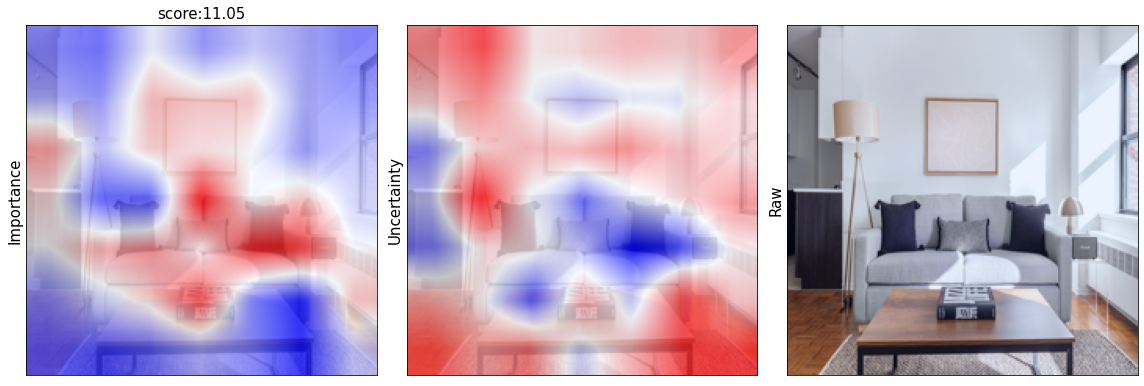

In [57]:
show_RELAX_one_img(ds, uniqueness, model, indices=idx_common["living_room"], scene="living_room", most_unique=None, most_common=1)

100%|██████████| 1/1 [00:29<00:00, 29.16s/it]


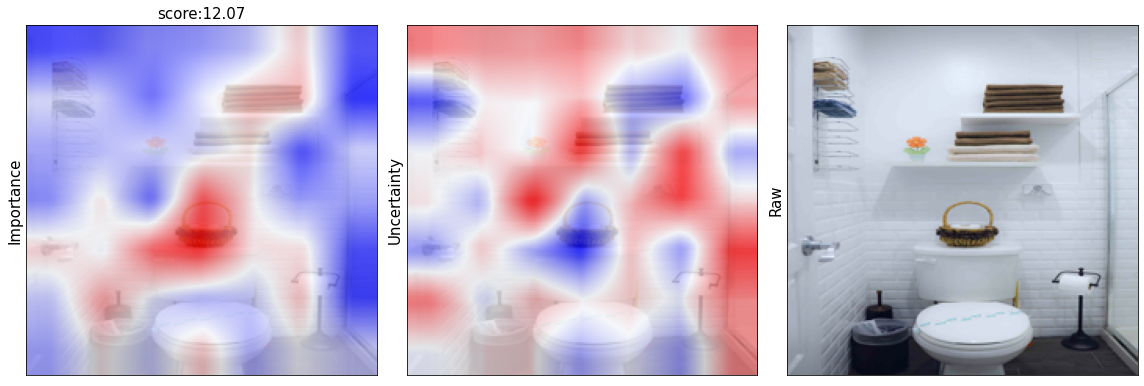

In [58]:
show_RELAX_one_img(ds, uniqueness, model, indices=idx_common["bathroom"], scene="bathroom", most_unique=None, most_common=1)

## RELAX-Unique

100%|██████████| 1/1 [00:45<00:00, 45.45s/it]
<ipython-input-18-6a61e14b5261>:251: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


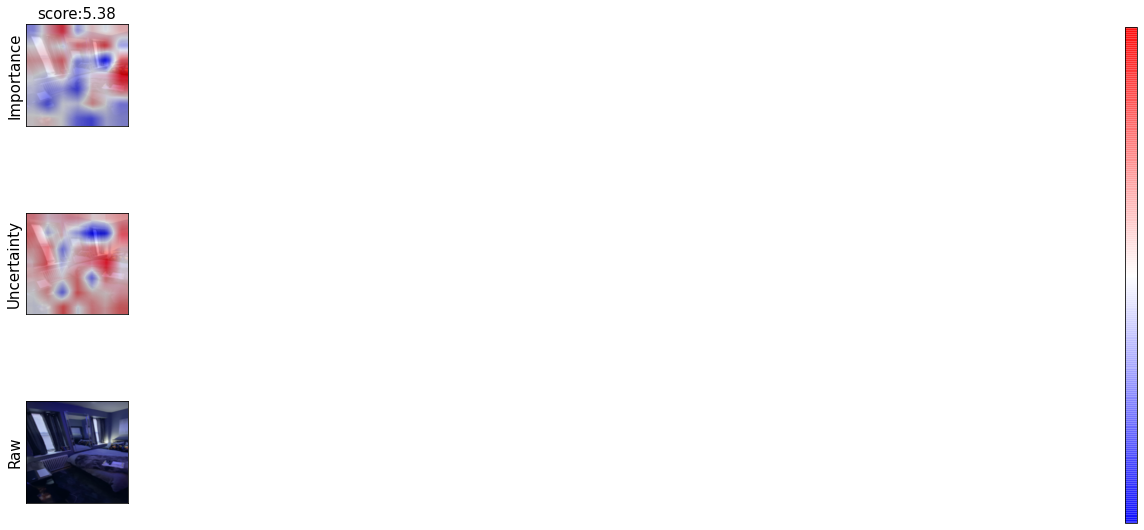

In [30]:
show_RELAX(ds, uniqueness, model, indices=idx_unique["bedroom"], scene="bedroom", most_unique=1, most_common=None)

In [26]:
show_RELAX(ds, uniqueness, model, indices=idx_unique["kitchen"], scene="kitchen", most_unique=1, most_common=None)

In [27]:
show_RELAX(ds, uniqueness, model, indices=idx_unique["living_room"], scene="living_room", most_unique=1, most_common=None)

In [28]:
show_RELAX(ds, uniqueness, model, indices=idx_unique["bathroom"], scene="bathroom", most_unique=1, most_common=None)

# Analysis of Uniqueness

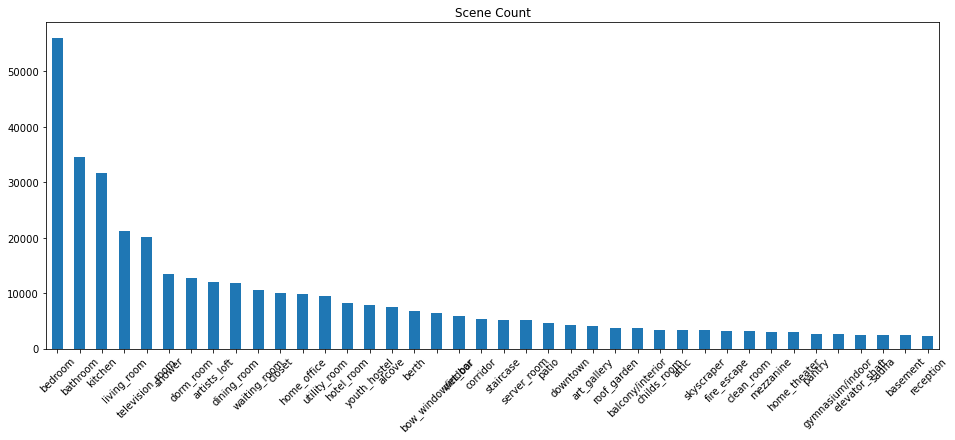

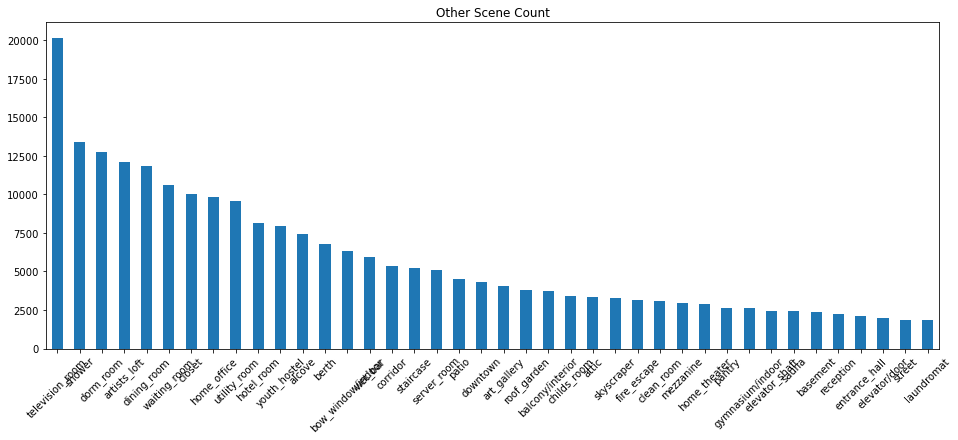

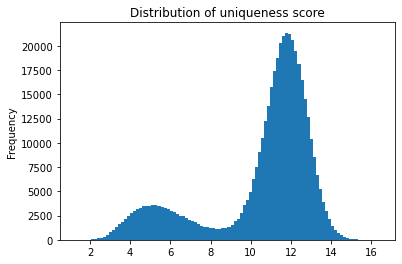

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## uniqueness file
file_path="./output/08-05_01:37:26/"
uniqueness = pd.read_pickle(file_path + "/uniqueness.pkl")

plt.figure(figsize=(16,6))
_ = uniqueness.iloc[:,2].value_counts()[:40].plot.bar(rot=45, title="Scene Count")
plt.figure(figsize=(16,6))
_ = uniqueness[~uniqueness.scene.isin(["bedroom","bathroom","living_room","kitchen"])].iloc[:,2].value_counts()[:40].plot.bar(rot=45, title="Other Scene Count")
plt.figure()
_ = uniqueness.loss.plot.hist(bins=100,title="Distribution of uniqueness score")

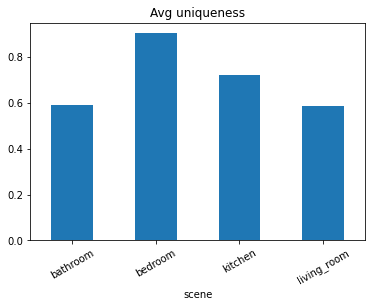

In [2]:
## Average uniqueness ranked by scenes
t = uniqueness.copy()
t["loss"] = t["loss"].sub(uniqueness.groupby("scene")["loss"].transform("mean"))
t = t.groupby("scene")["loss"].mean().rank(pct=True)
_ = t[t.index.isin(["bedroom","bathroom","living_room","kitchen"])].plot.bar(rot=30,title="Avg uniqueness")

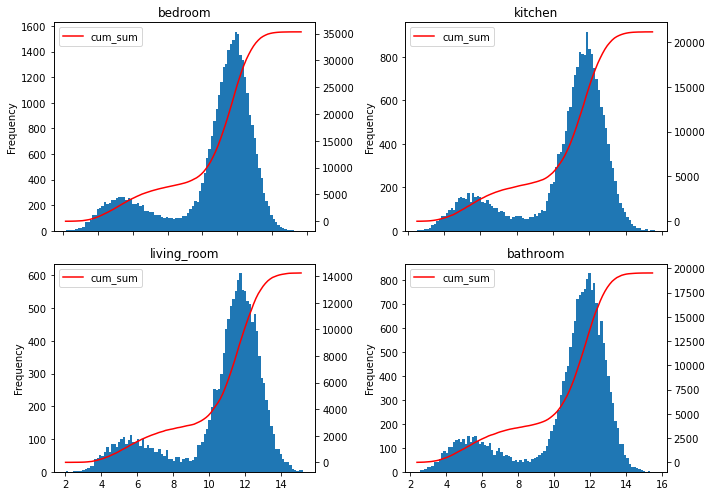

In [5]:
def plot_scene_dist(uniqueness, ax, scene="bedroom"):
    idx = uniqueness["scene"]==scene
    uniqueness[idx]["loss"].plot.hist(bins=100,title=scene,ax=ax)
    ax2 = ax.twinx()
    t = pd.cut(uniqueness[idx]["loss"],100).value_counts()
    t.index = [i.left for i in t.index]
    t.name = "cum_sum"
    t = t.sort_index()
    np.cumsum(t).plot(ax=ax2, color="r", legend=True)
    
    
fig,ax = plt.subplots(2,2,figsize=(10,7))
plot_scene_dist(uniqueness, ax[0,0], "bedroom")
plot_scene_dist(uniqueness, ax[0,1], "kitchen")
plot_scene_dist(uniqueness, ax[1,0], "living_room")
plot_scene_dist(uniqueness, ax[1,1], "bathroom")
plt.tight_layout()

In [6]:
print(t.sort_values())

scene
marsh             0.005525
soccer_field      0.005525
water_park        0.005525
lobby             0.011050
pavilion          0.013812
                    ...   
plaza             0.988950
alley             0.991713
yard              0.994475
elevator_lobby    0.997238
hardware_store    1.000000
Name: loss, Length: 362, dtype: float64


## PS_data uniqueness

In [7]:
import pandas as pd
import numpy as np
import h5py
from PIL import Image
import glob


file_path="./output/09-16_00:40:59/"
uniqueness = pd.read_pickle(file_path + "/train_loss.pkl")

img_folder = "./output/data/ps/*"


img_ids = []
for path in list(glob.glob(img_folder)):
    t = path.split("/")[-1]
    property_id = t.split("-")[0]
    image_id = ''.join(t.split("-")[1:])
    img_ids.append((property_id, image_id))

img_ids = pd.MultiIndex.from_tuples(img_ids)
append = uniqueness.loc[img_ids]
append.sort_index()

loss
44798876 miso#Hosting44798876#original#49fd711ad7f544aba...  2.735458
         miso#Hosting44798876#original#49fd711ad7f544aba...  0.601251
         miso#Hosting44798876#original#49fd711ad7f544aba...  0.444853
51548261 prohostapi#Hosting51548261#original#1637163a337...  1.696054
         prohostapi#Hosting51548261#original#1637163a337...  0.261581
         prohostapi#Hosting51548261#original#1637163a337...  3.921769
         prohostapi#Hosting51548261#original#1637163a337...  5.358766
52421812 miso#Hosting52421812#original#c7241fa530a241a5a...  4.941917
         miso#Hosting52421812#original#c7241fa530a241a5a...  1.371899
         miso#Hosting52421812#original#c7241fa530a241a5a...  2.331874
5384643  67674158#8fbbd9ef_original.JPG                      5.476419
         67674158#8fbbd9ef_originalr1.JPG                    4.516017
         67674158#8fbbd9ef_originalr2.JPG                    5.328836